In [ ]:
#===============================================================
# Þessi hluti býr til functions sem eru notuð seinna í kóðanum.
#===============================================================

import math as m
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def ydot(yi, L=2, g=9.81):
    return [yi[1], (-g/L)*m.sin(yi[0])]

def eulerstep(yi, h, func, L=2, g=9.81):
    return [x + h*func(yi,L,g)[i] for i,x in enumerate(yi)]

def euler(y0, T, n, L=2, g=9.81):
    h = T/n
    y = [y0]

    for i in range(n-1):
        y.append(eulerstep(y[i], h, ydot, L, g))

    theta = []
    omega = []

    for x in y:
        theta.append(x[0])
        omega.append(x[1])

    return theta, omega

def f(y):
    theta, omega = y
    g, L = 9.81, 2
    d_theta = omega
    d_omega = -(g/L)*m.sin(theta)
    return np.array([d_theta,d_omega])

def f2(start, m1=1, m2=1, l1=2, l2=2, g=9.81):
    
    # start = [y1, y2, y3, y4] = [θ1, θ2, ω1, ω2]
    y1 = start[0]
    y2 = start[1]
    y3 = start[2]
    y4 = start[3]

    delta = y2-y1 # Δ = θ2 - θ1

    a = m2*l1*(y3**2)*m.sin(delta)*m.cos(delta)
    b = m2*g*m.sin(y2)*m.cos(delta)
    c = m2*l2*(y4**2)*m.sin(delta)
    d = (m1+m2)*g*m.sin(y1)
    e = (m1+m2)*l1
    f = m2*l1*((1-m.cos(2*delta))/2)
    func1 = (a+b+c-d)/(e-f)
    i = m2*l2*(y4**2)*m.sin(delta)*m.cos(delta)
    j = (m1+m2)*(g*m.sin(y1)*m.cos(delta)-l1*(y3**2)*m.sin(delta)-g*m.sin(y2))
    k = (m1+m2)*l2
    l = m2*l2*((1-m.cos(2*delta))/2)
    func2 = (-i+j)/(k-l)

    return np.array([y3, y4, func1, func2])

def RKsolver_Y4(y0, T, n, f, y_final=''): # modified for vector y 4x1

    h = T / n  # time step

    y = y0

    # y0 = [y1, y2, y3, y4] = [θ1, θ2, ω1, ω2]
    y1 = [y0[0]]
    y2 = [y0[1]]
    y3 = [y0[2]]
    y4 = [y0[3]]

    for _ in range(n):
        k1 = f(y)
        k2 = f(y + 0.5*h*k1)
        k3 = f(y + 0.5*h*k2)
        k4 = f(y + h*k3)

        y = y + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
        y1.append(y[0])
        y2.append(y[1])
        y3.append(y[2])
        y4.append(y[3])
    if y_final == 'y':
        return np.array(y1[-1], y2[-1], y3[-1], y4[-1])
    else:
        return np.array([y1, y2, y3, y4]) # θ1:list, θ2:list, ω1:list, ω2:list

def save_animation(anim, filename="vid.mp4", fps=30):
    
    choice = input("Make video file? (Y/N): ").strip().lower()
    if choice == "y":
        if animation.writers.is_available("ffmpeg"):
            Writer = animation.writers["ffmpeg"]
            writer = Writer(fps=fps, metadata=dict(artist="Me"), bitrate=1800)
            anim.save(filename, writer=writer)
            print("Saved to:", filename)
        else:
            from matplotlib.animation import PillowWriter

            base, _ = os.path.splitext(filename)
            gif_filename = base + ".gif"

            writer = PillowWriter(fps=fps)
            anim.save(gif_filename, writer=writer)
            print("ffmpeg not available – saved GIF instead:", gif_filename)
    else:
        print("Video not saved.")

def mjaaa(start, m1=1, m2=1, l1=2, l2=2, g=9.81):
    
    # start = [y1, y2, y3, y4] = [θ1, θ2, ω1, ω2]
    y1 = start[0]
    y2 = start[1]
    y3 = start[2]
    y4 = start[3]

    delta = y2-y1 # Δ = θ2 - θ1

    a = m2*l1*(y3**2)*m.sin(delta)*m.cos(delta)
    b = m2*g*m.sin(y2)*m.cos(delta)
    c = m2*l2*(y4**2)*m.sin(delta)
    d = (m1+m2)*g*m.sin(y1)
    e = (m1+m2)*l1
    f = m2*l1*((1-m.cos(2*delta))/2)
    func1 = (a+b+c-d)/(e-f)
    i = m2*l2*(y4**2)*m.sin(delta)*m.cos(delta)
    j = (m1+m2)*(g*m.sin(y1)*m.cos(delta)-l1*(y3**2)*m.sin(delta)-g*m.sin(y2))
    k = (m1+m2)*l2
    l = m2*l2*((1-m.cos(2*delta))/2)
    func2 = (-i+j)/(k-l)

    return np.array([y3, y4, func1, func2])
    return np.array([y3, y4, func1, func2]) 

def make_multi_pendulums_plt(pendulums_list, theta, filename='vid.mp4', fps=30):
    """
    pendulums_list: List of pendulums. 
                    Each element is a list/tuple of two tuples: [(x1, y1), (x2, y2)]
                    representing mass 1 and mass 2 coordinates arrays.
    theta: Used only for frames count len(theta).
    """

    plt.close("all")
    fig = plt.figure()
    ax = fig.add_subplot(
        111, autoscale_on=False,
        xlim=(-5, 5), ylim=(-5, 5),
        aspect="equal"
    )
    plt.xlabel("Lengdareining")
    plt.ylabel("Lengdareining")
    fig.tight_layout()

    FPS_PLAY = fps
    
    # Colors to distinguish different double pendulums
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

    line_objects = []
    circle_objects = []

    # Initialize all pendulums
    for idx, p_data in enumerate(pendulums_list):
        # p_data should be [(x1, y1), (x2, y2)]
        (x1, y1), (x2, y2) = p_data
        
        col = colors[idx % len(colors)]

        # Mass 1 (connected to origin)
        line1, = ax.plot([0, x1[0]], [0, y1[0]], color=col, lw=2, alpha=0.7)
        bob1 = ax.add_patch(plt.Circle((x1[0], y1[0]), 0.1, fc=col, zorder=3))

        # Mass 2 (connected to Mass 1)
        line2, = ax.plot([x1[0], x2[0]], [y1[0], y2[0]], color=col, lw=2, alpha=0.7)
        bob2 = ax.add_patch(plt.Circle((x2[0], y2[0]), 0.1, fc=col, zorder=3))

        # Store in flat lists for the animation update
        # Structure: [p1_l1, p1_l2, p2_l1, p2_l2, ...]
        line_objects.extend([line1, line2])
        circle_objects.extend([bob1, bob2])

    def init():
        for line in line_objects:
            line.set_data([], [])
        for circ in circle_objects:
            circ.center = (-1000, -1000)
        return line_objects + circle_objects

    def animate(i):
        # Update every pendulum
        for idx, p_data in enumerate(pendulums_list):
            (x1, y1), (x2, y2) = p_data
            
            # Retrieve the specific objects for this pendulum
            l1_obj = line_objects[idx*2]
            l2_obj = line_objects[idx*2 + 1]
            b1_obj = circle_objects[idx*2]
            b2_obj = circle_objects[idx*2 + 1]

            # Current coordinates
            if i < len(x1):
                cx1, cy1 = x1[i], y1[i]
                cx2, cy2 = x2[i], y2[i]

                l1_obj.set_data([0, cx1], [0, cy1])
                b1_obj.center = (cx1, cy1)

                l2_obj.set_data([cx1, cx2], [cy1, cy2])
                b2_obj.center = (cx2, cy2)
        
        return line_objects + circle_objects

    anim = animation.FuncAnimation(
        fig, animate, frames=len(theta),
        interval=1000/FPS_PLAY, blit=True,
        init_func=init
    )

    plt.show()

    choice = input("Make video file? (Y/N): ").strip().lower()
    if choice == "y":
        if animation.writers.is_available("ffmpeg"):
            Writer = animation.writers["ffmpeg"]
            writer = Writer(fps=fps, metadata=dict(artist="Me"), bitrate=1800)
            anim.save(filename, writer=writer)
            print("Saved to:", filename)
        else:
            from matplotlib.animation import PillowWriter

            base, _ = os.path.splitext(filename)
            gif_filename = base + ".gif"

            writer = PillowWriter(fps=fps)
            anim.save(gif_filename, writer=writer)
            print("ffmpeg not available – saved GIF instead:", gif_filename)
    else:
        print("Video not saved.")

def makeDoublePendulumCoords(y0, T, n, l1=2, l2=2):
    '''
    y0=[theta1_0, theta2_0, omega1_0, omega2_0]
    '''

    theta1, theta2, omega1, omega2 = RKsolver_Y4(y0, T, n, mjaaa)
    theta_both = [theta1,theta2]

    x1 = [l1*m.sin(theta) for theta in theta1]
    y1 = [-l1*m.cos(theta) for theta in theta1]
    x2 = [l2*m.sin(theta_both[0][i])+l2*m.sin(theta_both[1][i]) for i in range(len(theta1))]
    y2 = [-l1*m.cos(theta_both[0][i])-l2*m.cos(theta_both[1][i]) for i in range(len(theta1))]
    return ((x1, y1), (x2, y2))
    #f.make_plt([(x1, y1),(x2, y2)], theta1, filename, fps)

def getDistance(x1, y1, x2, y2):
    return m.sqrt((x2-x1)**2 + (y2-y1)**2)

def RKsolver_Y6(y0, T, n, f, y_final=''): # modified for vector y 6x1

    h = T / n  # time step

    y = y0

    # y0 = [y1, y2, y3, y4, y5, y6] = [θ1, θ2, θ3, ω1, ω2, ω3]
    y1 = [y0[0]]
    y2 = [y0[1]]
    y3 = [y0[2]]
    y4 = [y0[3]]
    y5 = [y0[4]]
    y6 = [y0[5]]

    for _ in range(n):
        k1 = f(y)
        k2 = f(y + 0.5*h*k1)
        k3 = f(y + 0.5*h*k2)
        k4 = f(y + h*k3)

        y = y + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
        y1.append(y[0])
        y2.append(y[1])
        y3.append(y[2])
        y4.append(y[3])
        y5.append(y[4])
        y6.append(y[5])

    if y_final == 'y':
        return np.array([y1[-1], y2[-1], y3[-1], y4[-1], y5[-1], y6[-1]])
    else:
        return np.array([y1, y2, y3, y4, y5, y6]) # θ1:list, θ2:list, θ3:list, ω1:list, ω2:list, ω3:list

def omegaDot(theta1, theta2, omega1, omega2, m1=1, m2=1, L1=2, L2=2, g=9.81):
    delta = theta2 - theta1
    #Teljari í omega1dot, aðskilið með + eða -
    T11 = m2*L1*(omega1**2)*m.sin(delta)*m.cos(delta)
    T12 = m2*g*m.sin(theta2)*m.cos(delta)
    T13 = m2*L2*(omega2**2)*m.sin(delta)
    T14 = -(m1+m2)*g*m.sin(theta1)

    #Nefnari í omega1dot, aðskilið með + eða -
    N1 = (m1+m2)*L1
    N2 = -m2*L1*(m.cos(delta)**2)
    
    omega1dot = (T11+T12+T13+T14)/(N1+N2)

    #Teljari í omega2dot, aðskilið með + eða -
    T21 = -m2*L2*(omega2**2)*m.sin(delta)*m.cos(delta)

def f3(state, m1=1.0, m2=1.0, m3=1.0, l1=2.0, l2=2.0, l3=2.0, g=9.81):

    th1, th2, th3, w1, w2, w3 = state
    th = np.array([th1, th2, th3], dtype=float)
    w = np.array([w1, w2, w3], dtype=float)
    ls = [l1, l2, l3]
    ms = [m1, m2, m3]

    # Jacobian
    Js = []
    for r in range(3):
        J = np.zeros((2,3), dtype=float)
        for j in range(r+1):
            J[0, j] = ls[j] * m.cos(th[j])
            J[1, j] = ls[j] * m.sin(th[j])
        Js.append(J)

    M = np.zeros((3,3), dtype=float)
    for r in range(3):
        Jr = Js[r]
        M += ms[r] * (Jr.T @ Jr)

    dM = [np.zeros((3,3), dtype=float) for _ in range(3)]
    for k in range(3):
        for r in range(3):
            if k <= r:
                dJr = np.zeros((2,3), dtype=float)
                dJr[0, k] = - ls[k] * m.sin(th[k]) 
                dJr[1, k] =   ls[k] * m.cos(th[k]) 
                Jr = Js[r]
                dM_k_r = ms[r] * (dJr.T @ Jr + Jr.T @ dJr)
                dM[k] += dM_k_r

    dMdt = np.zeros((3,3), dtype=float)
    for k in range(3):
        dMdt += dM[k] * w[k]

    q_vec = np.zeros(3, dtype=float)
    for k in range(3):
        q_vec[k] = float(w @ (dM[k] @ w))

    dV = np.zeros(3, dtype=float)
    for k in range(3):
        sum_m = 0.0
        for r in range(k, 3):
            sum_m += ms[r]
        dV[k] = sum_m * g * ls[k] * m.sin(th[k])

    RHS = - (dMdt @ w - 0.5 * q_vec + dV)

    try:
        acc = np.linalg.solve(M, RHS)
    except np.linalg.LinAlgError:
        acc = np.linalg.lstsq(M, RHS, rcond=None)[0]

    return np.array([w1, w2, w3, acc[0], acc[1], acc[2]], dtype=float)

def RKsolverLotkaVolterra(y0, T, n, f):

    y = np.array(y0, dtype=float)
    h = T / n  # time step
    theta = [y0[0]]
    omega = [y0[1]]

    for _ in range(n):
        k1 = f(y)
        k2 = f(y + 0.5*h*k1)
        k3 = f(y + 0.5*h*k2)
        k4 = f(y + h*k3)

        y = y + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
        theta.append(y[0])
        omega.append(y[1])

    return theta, omega

def make_plt(*args, filename='vid.mp4', fps=30, frame=5):

    if len(args) == 3:
        x, y, theta = args
        pendulums = [(x, y)]

    elif len(args) == 2:
        pendulums, theta = args
    else:
        raise TypeError(
            "make_plt expected either (x, y, theta) or (pendulums, theta, ...)"
        )

    num_p = len(pendulums)

    plt.close("all")
    fig = plt.figure()
    ax = fig.add_subplot(
        111, autoscale_on=False,
        xlim=(-frame, frame), ylim=(-frame, frame),
        aspect="equal"
    )
    plt.xlabel("Lengdareining")
    plt.ylabel("Lengdareining")
    fig.tight_layout()

    FPS_PLAY = fps

    line_objects = []
    circle_objects = []

    for idx, (x_seg, y_seg) in enumerate(pendulums):
        if idx == 0:
            x0, y0 = 0.0, 0.0
        else:
            x_prev, y_prev = pendulums[idx - 1]
            x0, y0 = x_prev[0], y_prev[0]

        line, = ax.plot([x0, x_seg[0]], [y0, y_seg[0]], "b-", lw=2)
        bob = ax.add_patch(
            plt.Circle((x_seg[0], y_seg[0]), 0.1, fc="r", zorder=3)
        )

        line_objects.append(line)
        circle_objects.append(bob)

    def init():
        for line in line_objects:
            line.set_data([], [])
        for circ in circle_objects:
            circ.center = (-1000, -1000)
        return line_objects + circle_objects

    def animate(i):
        x_joint, y_joint = 0.0, 0.0

        for idx, (x_seg, y_seg) in enumerate(pendulums):
            x_i = x_seg[i]
            y_i = y_seg[i]

            line = line_objects[idx]
            bob = circle_objects[idx]

            line.set_data([x_joint, x_i], [y_joint, y_i])
            bob.center = (x_i, y_i)

            x_joint, y_joint = x_i, y_i

        return line_objects + circle_objects

    anim = animation.FuncAnimation(
        fig, animate, frames=len(theta),
        interval=1000 / FPS_PLAY, blit=True,
        init_func=init
    )

    plt.show()

    choice = input("Make video file? (Y/N): ").strip().lower()

    if choice == "y":
        if animation.writers.is_available("ffmpeg"):
            Writer = animation.writers["ffmpeg"]
            writer = Writer(fps=fps, metadata=dict(artist="Me"), bitrate=1800)
            anim.save(filename, writer=writer)
            print("Saved to:", filename)
        else:
            from matplotlib.animation import PillowWriter

            base, _ = os.path.splitext(filename)
            gif_filename = base + ".gif"

            writer = PillowWriter(fps=fps)
            anim.save(gif_filename, writer=writer)
            print("ffmpeg not available – saved GIF instead:", gif_filename)
    else:
        print("Video not saved.")

    return anim


In [ ]:
#==================
# Þetta er dæmi 2.
#==================

import math as m
import matplotlib.pyplot as plt

y0 = [1, 1] #!!!!!!!!!!!!!!!!

y = [y0]
n = 100
T = 3
h = T/n

for i in range(n-1):
    y.append(eulerstep(y[i], h, ydot))

theta = []
omega = []

for x in y:
    theta.append(x[0])
    omega.append(x[1])

# # Uncomment ef þið viljið fá niðurstöður útprentaðar!
# for i in range(len(theta)):
#     print(i, theta[i], omega[i])

# # Uncomment ef þið viljið fá niðurstöður plottaðar!
# x = np.linspace(0, T, n)
# plt.plot(x, theta)
# plt.show()

In [ ]:
#==================
# Þetta er dæmi 3.
#==================

import math as m

# Fastar
y0 = [m.pi/12, 0]
T = 20
n = 500
L=2

theta, omega = euler(y0,T,n)

x = [m.sin(i)*L for i in theta]
y = [-m.cos(i)*L for i in theta]

anim = make_plt(x,y,theta)

# save_animation_prompt(anim)

In [ ]:
#==================
# Þetta er dæmi 4.
#==================

import math as m

y0 = [m.pi/2, 0]
T = 20
n = 500
L=2

theta, omega = euler(y0,T,n)

x = [m.sin(i)*L for i in theta]
y = [-m.cos(i)*L for i in theta]

anim = make_plt(x,y,theta)

# save_animation_prompt(anim)

In [ ]:
#==================
# Þetta er dæmi 5.
#==================

import math as m

T = 20
n = 500
L = 2

y0 = [[m.pi/12, 0],[m.pi/2, 0]]

for y0 in y0:
    theta, omega = RKsolverLotkaVolterra(y0, T, n, f)
    x = [m.sin(i)*L for i in theta]
    y = [-m.cos(i)*L for i in theta]
    anim = make_plt(x, y, theta)
    save_animation(anim,'V3-5.mp4')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

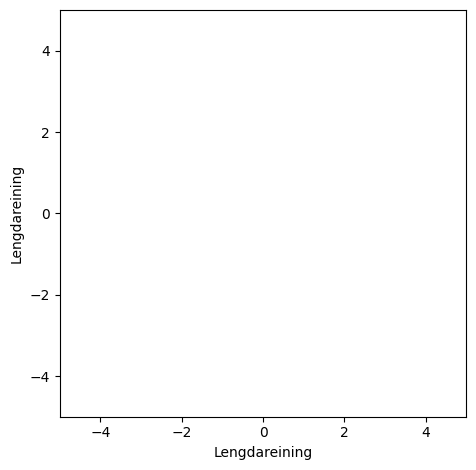

In [18]:
#==================
# Þetta er dæmi 7.
#==================

import math as m

# Fastar
l1 = l2 = 2
m1 = m2 = 1
T = 20
n = 250

# Upphafsgildi
y0 = [m.pi/3, m.pi/6, 0, 0] # [θ1, θ2, ω1, ω2]

theta1, theta2, omega1, omega2 = RKsolver_Y4(y0, T, n, f2)
theta_both = [theta1,theta2]

x1 = [l1*m.sin(theta) for theta in theta1]
y1 = [-l1*m.cos(theta) for theta in theta1]
x2 = [l2*m.sin(theta_both[0][i])+l2*m.sin(theta_both[1][i]) for i in range(len(theta1))]
y2 = [-l1*m.cos(theta_both[0][i])-l2*m.cos(theta_both[1][i]) for i in range(len(theta1))]

make_plt([(x1, y1),(x2, y2)],theta1,'V3-7.mp4')

In [19]:
#==================
# Þetta er dæmi 8.
#==================

import math as m

# Fastar
l1 = l2 = 2
m1 = m2 = 1
T = 20
n = 250

# Upphafsgildi  [θ1, θ2, ω1, ω2]
y0 = [m.pi/3, m.pi/6, 0.5, 0] 

theta1, theta2, omega1, omega2 = RKsolver_Y4(y0, T, n, f2)
theta_both = [theta1, theta2]

x1 = [l1 * m.sin(theta) for theta in theta1]
y1 = [-l1 * m.cos(theta) for theta in theta1]

x2 = [l1 * m.sin(theta_both[0][i]) + l2 * m.sin(theta_both[1][i])
      for i in range(len(theta1))]
y2 = [-l1 * m.cos(theta_both[0][i]) - l2 * m.cos(theta_both[1][i])
      for i in range(len(theta1))]

make_path_plt([(x1, y1), (x2, y2)], theta1, filename="V3-8.mp4", fps=30)

NameError: name 'make_path_plt' is not defined

In [20]:
#==================
# Þetta er dæmi 9.
#==================

import matplotlib.pyplot as plt
import math as m

# Fastar
N = [200, 400, 800, 1600, 3200, 6400]
T = 20
h = [T/n for n in N]
y0 = [m.pi-0.2,m.pi,0,0]

sol = []
for n in N:
    res = RKsolver_Y4(y0, T, n, f2,'y')
    sol.append(res)

res_ref = RKsolver_Y4(y0, T, 12800, f2,'y')

errors = []
for res in sol:        
    sum = 0
    for i in range(len(res_ref)):
        sum += (res[i] - res_ref[i])**2
    errors.append(m.sqrt(sum))

plt.figure()
plt.scatter(N, errors, marker='o', label="RK-error")
plt.plot(N, errors)
plt.scatter(N, h, marker='o', label="h^4")
plt.xlabel("h = T/n")
plt.plot(N, h)
plt.ylabel("skekkja")
plt.legend()
plt.grid(True, which="both")
plt.show()

TypeError: array() takes from 1 to 2 positional arguments but 4 were given

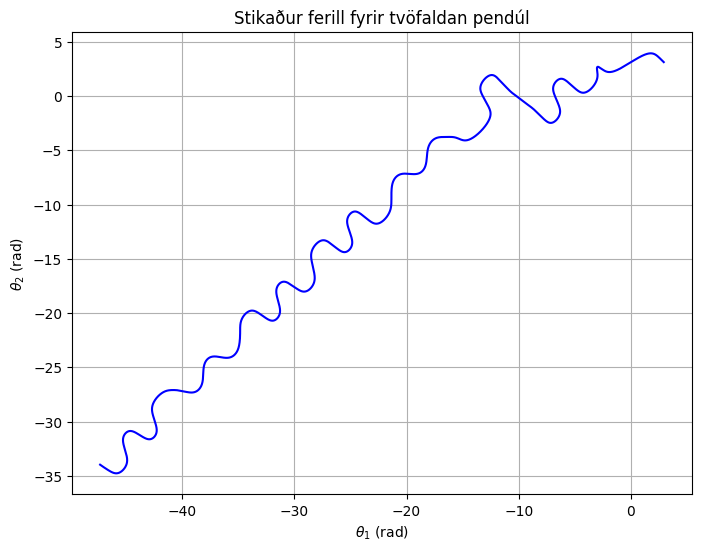

In [21]:
#==================
# Þetta er dæmi 10.
#==================

import math as m
import matplotlib.pyplot as plt

n = 6400
T = 20
y0 = [m.pi-0.2,m.pi,0,0]

theta1,theta2,omega1,omega2 = RKsolver_Y4(y0, T, n, f2)

plt.figure(figsize=(8,6))
plt.plot(theta1, theta2, color='blue')
plt.xlabel(r'$\theta_1$ (rad)')
plt.ylabel(r'$\theta_2$ (rad)')
plt.title('Stikaður ferill fyrir tvöfaldan pendúl')
plt.grid(True)
plt.show()

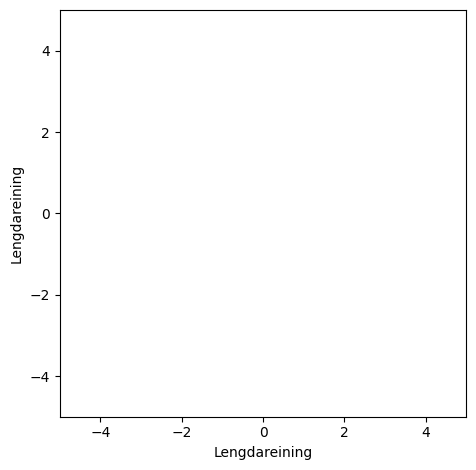

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [22]:
#==================
# Þetta er dæmi 11.
#==================

import math as m

epsilons = [3, 5, 8]

for x in epsilons:
    epsilon = 10**(-x)
    y10 = [m.pi/2, m.pi/2, 0, 0]
    y20 = [epsilon + m.pi/2, epsilon + m.pi/2, 0, 0]

    pendulum1 = makeDoublePendulumCoords(y10, 120, 5000)
    pendulum2 = makeDoublePendulumCoords(y20, 120, 5000)

    make_multi_pendulums_plt([pendulum1, pendulum2], pendulum1[0][0], filename='V3-11_{}.mp4'.format(x), fps=30)

In [23]:
#==================
# Þetta er dæmi 12.
#==================

import math as m
import numpy as np

T = 200
n = 10000
DIST = 0.1

epsilon = 10**(-5)

theta0 = [k*m.pi/10 for k in range(10)]
seperation_times = np.zeros((10,10))

for x in theta0:
    for y in theta0:
        y10 = [x, y, 0, 0]
        y20 = [epsilon + x, epsilon + y, 0, 0]

        pendulum1 = makeDoublePendulumCoords(y10, T, n-1)
        pendulum2 = makeDoublePendulumCoords(y20, T, n-1)
        
        for i in range(len(pendulum1[1][0])):
            lower_ball1 = pendulum1[1]
            lower_ball2 = pendulum2[1]
            if getDistance(lower_ball1[0][i], lower_ball1[1][i], lower_ball2[0][i], lower_ball2[1][i]) > DIST:
                seperation_times[theta0.index(x)][theta0.index(y)] = T*i/n
                print(T*i/n)
                break

print(seperation_times)
print("0 þýðir að mismunur fannst ekki á bilinu")

80.08
25.12
16.62
18.9
36.4
10.98
23.56
17.14
69.94
66.46
102.1
37.06
15.22
27.04
28.56
39.66
22.72
10.1
176.94
82.36
40.6
22.98
7.66
6.92
27.66
58.32
189.3
47.48
59.52
33.1
17.98
13.22
5.38
6.42
8.68
9.54
24.8
39.84
50.58
37.52
20.82
10.74
7.26
4.88
8.16
7.64
7.88
7.04
7.38
31.78
7.92
9.12
7.9
6.2
13.76
6.62
8.5
9.84
6.94
13.22
5.32
6.0
5.04
11.1
[[  0.     0.     0.     0.     0.     0.    80.08  25.12  16.62  18.9 ]
 [  0.     0.     0.     0.     0.     0.     0.     0.    36.4   10.98]
 [  0.     0.     0.     0.     0.     0.     0.     0.    23.56  17.14]
 [  0.     0.     0.     0.     0.    69.94  66.46 102.1   37.06  15.22]
 [  0.     0.     0.     0.     0.    27.04  28.56  39.66  22.72  10.1 ]
 [  0.     0.   176.94  82.36   0.    40.6   22.98   0.     7.66   6.92]
 [ 27.66  58.32 189.3   47.48  59.52  33.1   17.98  13.22   5.38   6.42]
 [  8.68   9.54  24.8   39.84  50.58  37.52  20.82  10.74   7.26   4.88]
 [  8.16   7.64   7.88   7.04   7.38  31.78   7.92   9.12   7.9   

In [24]:
#===========================
# Þetta er frjálsi hlutinn.
#===========================

import math as m

# Fastar
l1 = l2 = l3 = 2
m1 = m2 = m3 = 1
T = 20
n = 5000

# Upphafsgildi
y0 = [m.pi/2,m.pi/2,m.pi/2, 0, 0, 0] # [θ1, θ2, θ3, ω1, ω2, ω3]

theta1, theta2, theta3, omega1, omega2, omega3 = RKsolver_Y6(y0, T, n, f3)

x1 = [l1*m.sin(theta) for theta in theta1]
y1 = [-l1*m.cos(theta) for theta in theta1]
x2 = [l1*m.sin(theta1[i])+l2*m.sin(theta2[i]) for i in range(len(theta1))]
y2 = [-l1*m.cos(theta1[i])-l2*m.cos(theta2[i]) for i in range(len(theta1))]
x3 = [l1*m.sin(theta1[i])+l2*m.sin(theta2[i])+l3*m.sin(theta3[i]) for i in range(len(theta1))]
y3 = [-l1*m.cos(theta1[i])-l2*m.cos(theta2[i])-l3*m.cos(theta3[i]) for i in range(len(theta1))]

make_plt([(x1, y1),(x2, y2),(x3, y3)],theta1,'V3-þrefaldur_pendúll.mp4',120,frame=6)

TypeError: make_plt expected either (x, y, theta) or (pendulums, theta, ...)